# Causal Forest & Feature Importance for Uplift

This notebook extends our uplift modeling with:

1. **Uplift Random Forest** (CausalML) - Purpose-built trees that split on uplift
2. **Causal Forest** (EconML) - Microsoft's implementation with honest estimation
3. **Feature Importance Analysis** - Which features drive treatment effect heterogeneity?

### Key Difference from Meta-Learners:
- Meta-learners (T/S/X) use standard ML models that optimize for **prediction accuracy**
- Causal Trees/Forests optimize for **treatment effect heterogeneity** directly


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# CausalML - Uplift Random Forest
from causalml.inference.tree import UpliftRandomForestClassifier

# EconML - Causal Forest
from econml.dml import CausalForestDML
from econml.grf import CausalForest

# For feature importance
from sklearn.inspection import permutation_importance

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

%matplotlib inline

print("✅ Libraries loaded successfully!")


✅ Libraries loaded successfully!


## 1. Load and Prepare Data


In [2]:
# Load data
df = pd.read_parquet('../data/raw/criteo_uplift.parquet')
print(f"Full dataset: {df.shape[0]:,} rows")

# Sample for training (Causal Forests are computationally intensive)
SAMPLE_SIZE = 200_000
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
print(f"Sample size: {df_sample.shape[0]:,} rows")

# Define features and targets
feature_cols = [f'f{i}' for i in range(12)]
X = df_sample[feature_cols].values
y = df_sample['conversion'].values
treatment = df_sample['treatment'].values

print(f"\nFeatures: {len(feature_cols)}")
print(f"Treatment rate: {treatment.mean()*100:.1f}%")
print(f"Conversion rate: {y.mean()*100:.3f}%")


Full dataset: 13,979,592 rows
Sample size: 200,000 rows

Features: 12
Treatment rate: 85.0%
Conversion rate: 0.322%


In [3]:
# Train/Test split
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, treatment, 
    test_size=0.3, 
    random_state=42,
    stratify=y
)

# Create DataFrames for easier handling
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df['y'] = y_train
train_df['treatment'] = t_train

test_df = pd.DataFrame(X_test, columns=feature_cols)
test_df['y'] = y_test
test_df['treatment'] = t_test

print(f"Training set: {len(X_train):,} rows")
print(f"Test set: {len(X_test):,} rows")


Training set: 140,000 rows
Test set: 60,000 rows


## 2. Uplift Random Forest (CausalML)

**How it differs from regular Random Forest:**
- Regular RF: Splits to minimize prediction error (Gini, entropy)
- Uplift RF: Splits to maximize **treatment effect difference** between child nodes

**Split Criteria Options:**
- `KL` (Kullback-Leibler divergence)
- `ED` (Euclidean Distance)
- `Chi` (Chi-squared)

The tree asks: *"Which split creates the biggest uplift difference between left and right?"*


In [4]:
# Train Uplift Random Forest
print("Training Uplift Random Forest...")
print("(This optimizes splits for uplift heterogeneity, not prediction accuracy)\n")

uplift_rf = UpliftRandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=100,
    min_samples_treatment=50,
    evaluationFunction='KL',  # Kullback-Leibler divergence
    control_name='0',
    random_state=42,
    n_jobs=-1
)

# CausalML expects treatment as string
t_train_str = t_train.astype(str)
t_test_str = t_test.astype(str)

uplift_rf.fit(X_train, treatment=t_train_str, y=y_train)

print("✅ Uplift Random Forest trained!")


Training Uplift Random Forest...
(This optimizes splits for uplift heterogeneity, not prediction accuracy)

✅ Uplift Random Forest trained!


In [5]:
# Predict uplift
uplift_rf_pred = uplift_rf.predict(X_test)

# The output is a DataFrame with columns for each treatment vs control comparison
print("Prediction output shape:", uplift_rf_pred.shape)
print("Columns:", uplift_rf_pred.columns.tolist() if hasattr(uplift_rf_pred, 'columns') else "Array")

# Extract the uplift (treatment '1' vs control '0')
if isinstance(uplift_rf_pred, pd.DataFrame):
    uplift_rf_scores = uplift_rf_pred['1'].values  # Treatment effect for treatment=1 vs control=0
else:
    uplift_rf_scores = uplift_rf_pred[:, 0]

print(f"\nUplift RF Predictions:")
print(f"  Mean: {uplift_rf_scores.mean()*100:.4f}%")
print(f"  Std:  {uplift_rf_scores.std()*100:.4f}%")
print(f"  Range: [{uplift_rf_scores.min()*100:.4f}%, {uplift_rf_scores.max()*100:.4f}%]")


Prediction output shape: (60000, 1)
Columns: Array

Uplift RF Predictions:
  Mean: 0.1692%
  Std:  0.6309%
  Range: [-1.3901%, 8.7975%]


## 3. Causal Forest (EconML)

**EconML's Causal Forest** (from Microsoft Research) has additional features:
- **Honest estimation**: Uses separate samples for splitting and estimation (reduces overfitting)
- **Confidence intervals**: Built-in uncertainty quantification
- **Asymptotic normality**: Theoretical guarantees for inference

Based on the Generalized Random Forest (GRF) framework by Athey, Tibshirani & Wager (2019).


In [6]:
# Train EconML Causal Forest
print("Training EconML Causal Forest...")
print("(Uses honest estimation with sample splitting)\n")

causal_forest = CausalForest(
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

# EconML expects: fit(X, T, Y)
causal_forest.fit(X_train, t_train, y_train)

print("✅ Causal Forest trained!")


Training EconML Causal Forest...
(Uses honest estimation with sample splitting)

✅ Causal Forest trained!


In [7]:
# Predict CATE (Conditional Average Treatment Effect)
cate_cf = causal_forest.predict(X_test).flatten()

print(f"Causal Forest CATE Predictions:")
print(f"  Mean: {cate_cf.mean()*100:.4f}%")
print(f"  Std:  {cate_cf.std()*100:.4f}%")
print(f"  Range: [{cate_cf.min()*100:.4f}%, {cate_cf.max()*100:.4f}%]")


Causal Forest CATE Predictions:
  Mean: 0.1811%
  Std:  0.9620%
  Range: [-1.2849%, 15.7594%]


In [8]:
# Get confidence intervals (unique feature of EconML)
cate_cf_low, cate_cf_high = causal_forest.predict_interval(X_test, alpha=0.05)

print("Causal Forest with 95% Confidence Intervals:")
print(f"  Average CI width: {(cate_cf_high.mean() - cate_cf_low.mean())*100:.4f} percentage points")

# Show example predictions with CIs
example_df = pd.DataFrame({
    'CATE (%)': cate_cf[:10] * 100,
    'CI Lower (%)': cate_cf_low[:10].flatten() * 100,
    'CI Upper (%)': cate_cf_high[:10].flatten() * 100
})
example_df['CI Width'] = example_df['CI Upper (%)'] - example_df['CI Lower (%)']
print("\nFirst 10 predictions with confidence intervals:")
example_df.round(4)


Causal Forest with 95% Confidence Intervals:
  Average CI width: 0.5585 percentage points

First 10 predictions with confidence intervals:


,CATE (%),CI Lower (%),CI Upper (%),CI Width
0,0.0772,-0.1067,0.2611,0.3678
1,-0.0307,-0.0768,0.0154,0.0922
2,-0.0167,-0.1135,0.0801,0.1936
3,0.0690,-0.0161,0.1541,0.1702
4,0.0446,-0.0809,0.1700,0.2509
5,-0.0011,-0.0071,0.0050,0.0121
6,0.0027,-0.1657,0.1711,0.3368
7,0.2427,-0.0901,0.5754,0.6654
8,-0.0011,-0.0071,0.0050,0.0121
9,-0.0011,-0.0071,0.0050,0.0121


## 4. Model Evaluation & Comparison


In [9]:
# Reuse the evaluation functions from notebook 2
def calc_uplift_curve(y_true, uplift_pred, treatment, n_bins=100):
    """Calculate uplift curve data by ranking users by predicted uplift."""
    df = pd.DataFrame({
        'y': y_true, 
        'uplift': uplift_pred, 
        'treatment': treatment
    })
    df = df.sort_values('uplift', ascending=False).reset_index(drop=True)
    
    results = []
    n = len(df)
    
    for i in range(1, n_bins + 1):
        k = int(n * i / n_bins)
        subset = df.iloc[:k]
        
        treated = subset[subset['treatment'] == 1]
        control = subset[subset['treatment'] == 0]
        
        if len(treated) > 0 and len(control) > 0:
            uplift = treated['y'].mean() - control['y'].mean()
            qini = uplift * k
        else:
            uplift = 0
            qini = 0
            
        results.append({
            'percentile': i / n_bins,
            'n_targeted': k,
            'uplift': uplift,
            'qini': qini
        })
    
    return pd.DataFrame(results)

def calc_qini_coefficient(y_true, uplift_pred, treatment):
    """Calculate Qini coefficient (area between model and random)."""
    curve = calc_uplift_curve(y_true, uplift_pred, treatment)
    model_area = np.trapz(curve['qini'], curve['percentile'])
    final_qini = curve['qini'].iloc[-1]
    random_area = 0.5 * final_qini
    return model_area - random_area

def calc_auuc(y_true, uplift_pred, treatment):
    """Calculate AUUC - Area Under Uplift Curve."""
    curve = calc_uplift_curve(y_true, uplift_pred, treatment)
    return np.trapz(curve['uplift'], curve['percentile'])

print("✅ Evaluation functions defined")


✅ Evaluation functions defined


In [10]:
# Evaluate both models
models = {
    'Uplift RF (CausalML)': uplift_rf_scores,
    'Causal Forest (EconML)': cate_cf
}

results = []
for name, preds in models.items():
    qini = calc_qini_coefficient(y_test, preds, t_test)
    auuc = calc_auuc(y_test, preds, t_test)
    results.append({
        'Model': name,
        'Qini Coefficient': qini,
        'AUUC': auuc,
        'Mean Predicted CATE': preds.mean(),
        'Std Predicted CATE': preds.std()
    })

comparison_df = pd.DataFrame(results)
comparison_df['Qini Rank'] = comparison_df['Qini Coefficient'].rank(ascending=False).astype(int)
comparison_df['AUUC Rank'] = comparison_df['AUUC'].rank(ascending=False).astype(int)

print("=" * 60)
print("MODEL COMPARISON: Causal Tree-Based Methods")
print("=" * 60)
comparison_df


MODEL COMPARISON: Causal Tree-Based Methods


,Model,Qini Coefficient,AUUC,Mean Predicted CATE,Std Predicted CATE,Qini Rank,AUUC Rank
0,Uplift RF (CausalML),30.854574,0.003241,0.001692,0.006309,1,1
1,Causal Forest (EconML),24.662078,0.002931,0.001811,0.009620,2,2


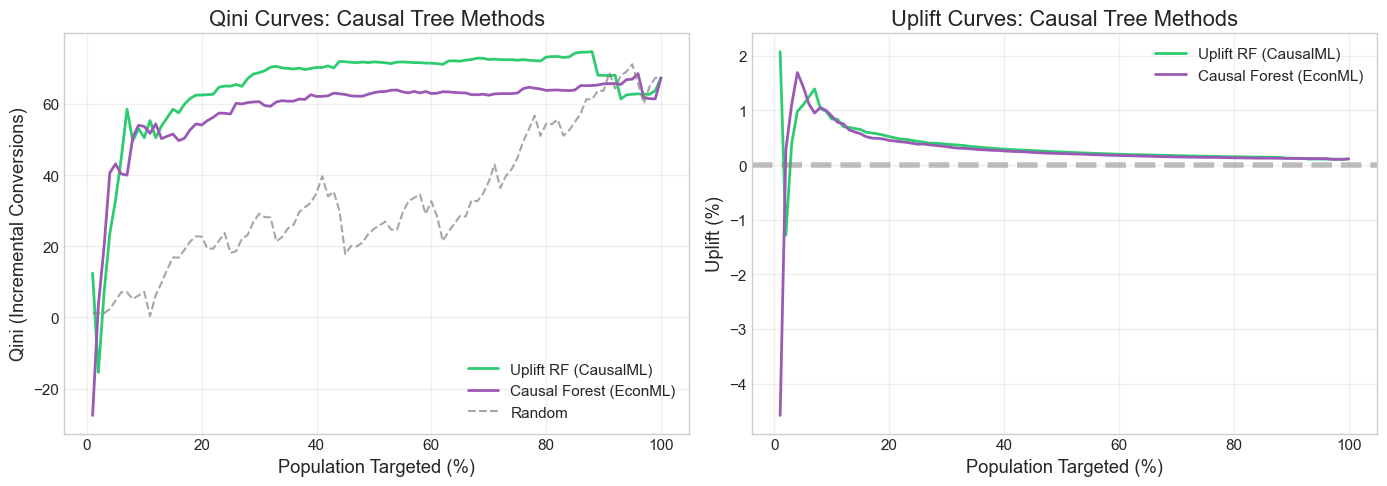

In [11]:
# Plot Qini curves for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Qini Curves
ax1 = axes[0]
colors = ['#2ecc71', '#9b59b6']

for (name, preds), color in zip(models.items(), colors):
    curve = calc_uplift_curve(y_test, preds, t_test)
    ax1.plot(curve['percentile'] * 100, curve['qini'], label=name, color=color, linewidth=2)

# Random baseline
random_curve = calc_uplift_curve(y_test, np.random.randn(len(y_test)), t_test)
ax1.plot(random_curve['percentile'] * 100, random_curve['qini'], 
         '--', color='gray', label='Random', linewidth=1.5, alpha=0.7)

ax1.set_xlabel('Population Targeted (%)')
ax1.set_ylabel('Qini (Incremental Conversions)')
ax1.set_title('Qini Curves: Causal Tree Methods')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Uplift Curves
ax2 = axes[1]
for (name, preds), color in zip(models.items(), colors):
    curve = calc_uplift_curve(y_test, preds, t_test)
    ax2.plot(curve['percentile'] * 100, curve['uplift'] * 100, label=name, color=color, linewidth=2)

ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Population Targeted (%)')
ax2.set_ylabel('Uplift (%)')
ax2.set_title('Uplift Curves: Causal Tree Methods')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Feature Importance for Uplift

**Key distinction**: Standard feature importance measures *predictive* power. For uplift, we want:

> **Which features drive *heterogeneity* in treatment effect?**

Three approaches:
1. **Built-in importance** - From Causal Forest's tree structure
2. **Permutation importance** - Shuffle a feature, measure drop in Qini
3. **SHAP for uplift** - Explain individual predictions


### 5.1 Built-in Feature Importance (Uplift RF)


Feature Importance from Uplift Random Forest:
(Higher = more important for treatment effect heterogeneity)



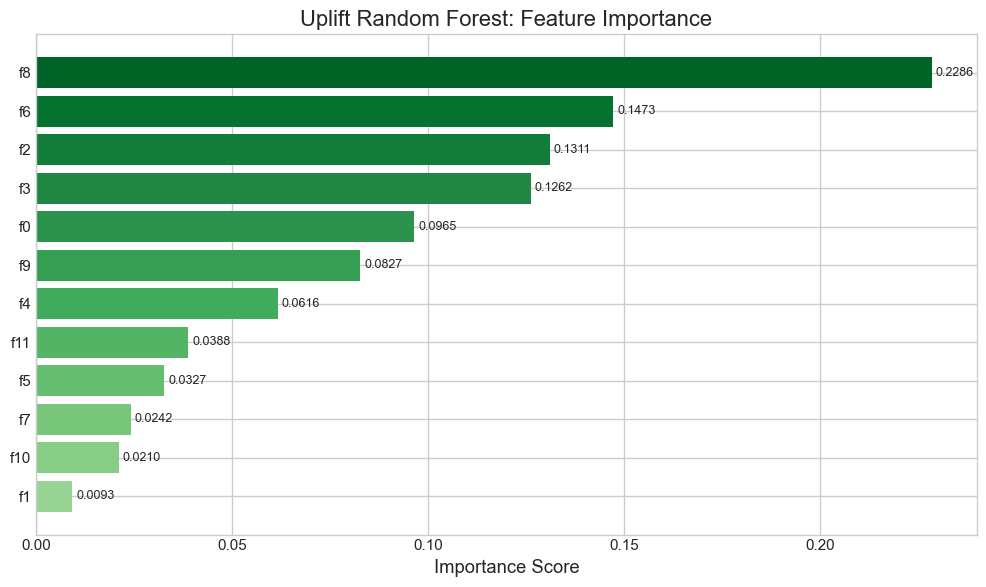

In [12]:
# Get feature importance from Uplift Random Forest
# This measures how much each feature contributes to uplift-based splits

try:
    uplift_fi = uplift_rf.feature_importances_
    fi_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': uplift_fi
    }).sort_values('Importance', ascending=False)
    
    print("Feature Importance from Uplift Random Forest:")
    print("(Higher = more important for treatment effect heterogeneity)\n")
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(fi_df)))[::-1]
    bars = ax.barh(fi_df['Feature'], fi_df['Importance'], color=colors)
    ax.set_xlabel('Importance Score')
    ax.set_title('Uplift Random Forest: Feature Importance')
    ax.invert_yaxis()
    
    # Add value labels
    for bar, val in zip(bars, fi_df['Importance']):
        ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    fi_df
except AttributeError:
    print("Feature importance not directly available. Using alternative method...")


### 5.2 Permutation Importance on Qini Score

**Idea**: Shuffle one feature at a time, measure how much the Qini coefficient drops.

If shuffling a feature causes a big Qini drop → that feature is important for ranking users by uplift.


In [13]:
def permutation_importance_qini(model, X, y, treatment, feature_names, n_repeats=5):
    """
    Calculate permutation importance using Qini coefficient as the metric.
    
    For each feature:
    1. Shuffle that feature's values
    2. Recalculate predictions and Qini
    3. Measure the drop from baseline
    """
    # Baseline Qini (with original features)
    baseline_preds = model.predict(X)
    if isinstance(baseline_preds, pd.DataFrame):
        baseline_preds = baseline_preds['1'].values
    baseline_preds = baseline_preds.flatten()
    baseline_qini = calc_qini_coefficient(y, baseline_preds, treatment)
    
    importance_scores = []
    
    for i, feat in enumerate(feature_names):
        drops = []
        for _ in range(n_repeats):
            # Shuffle this feature
            X_shuffled = X.copy()
            np.random.shuffle(X_shuffled[:, i])
            
            # Get new predictions
            shuffled_preds = model.predict(X_shuffled)
            if isinstance(shuffled_preds, pd.DataFrame):
                shuffled_preds = shuffled_preds['1'].values
            shuffled_preds = shuffled_preds.flatten()
            
            # Calculate new Qini
            shuffled_qini = calc_qini_coefficient(y, shuffled_preds, treatment)
            drops.append(baseline_qini - shuffled_qini)
        
        importance_scores.append({
            'Feature': feat,
            'Importance': np.mean(drops),
            'Std': np.std(drops)
        })
        
    return pd.DataFrame(importance_scores).sort_values('Importance', ascending=False)

print("✅ Permutation importance function defined")


✅ Permutation importance function defined


In [14]:
# Calculate permutation importance for Uplift RF
# Note: This can take a few minutes for large datasets

print("Calculating Permutation Importance for Uplift Random Forest...")
print("(Shuffling each feature and measuring Qini drop)\n")

# Use a smaller subset for speed
subset_size = 10000
indices = np.random.choice(len(X_test), size=subset_size, replace=False)
X_subset = X_test[indices]
y_subset = y_test[indices]
t_subset = t_test[indices]

perm_importance_df = permutation_importance_qini(
    uplift_rf, X_subset, y_subset, t_subset, feature_cols, n_repeats=3
)

print("Permutation Importance (Qini-based):")
print("Higher = feature more important for treatment effect ranking\n")
perm_importance_df


Calculating Permutation Importance for Uplift Random Forest...
(Shuffling each feature and measuring Qini drop)

Permutation Importance (Qini-based):
Higher = feature more important for treatment effect ranking



,Feature,Importance,Std
0,f0,8.534965,0.283349
3,f3,7.282442,1.156093
6,f6,6.042085,2.625807
2,f2,3.712592,0.453081
8,f8,3.251923,3.884062
4,f4,2.869640,2.320166
1,f1,0.174996,0.024514
5,f5,0.140996,0.050006
10,f10,0.077536,0.029822
11,f11,0.074459,0.094260


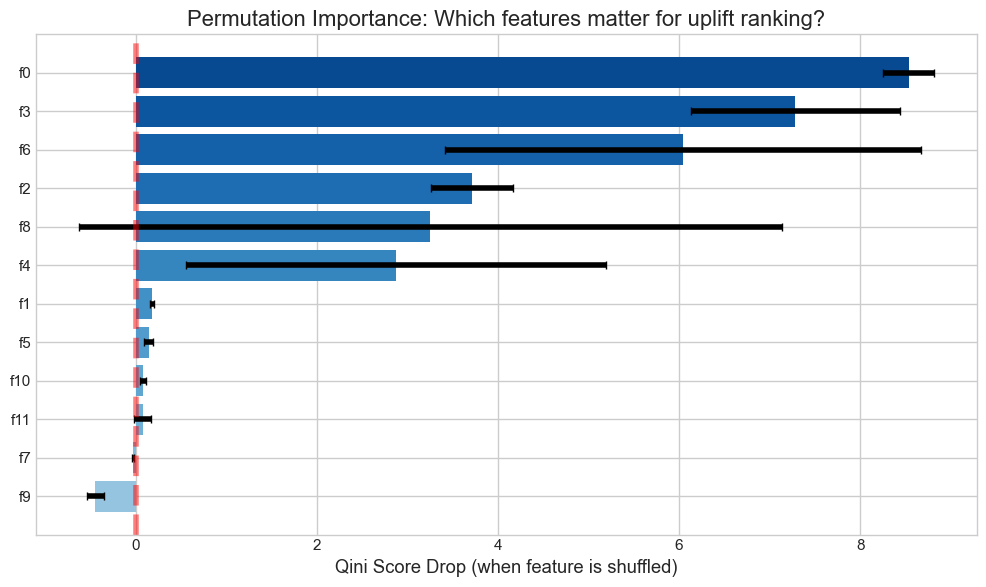

In [15]:
# Visualize permutation importance
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(perm_importance_df)))[::-1]
bars = ax.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], 
               xerr=perm_importance_df['Std'], color=colors, capsize=3)

ax.set_xlabel('Qini Score Drop (when feature is shuffled)')
ax.set_title('Permutation Importance: Which features matter for uplift ranking?')
ax.invert_yaxis()
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### 5.3 Treatment Effect Heterogeneity Analysis

Let's analyze how the predicted uplift varies across feature segments to understand which user characteristics drive treatment effect variation.


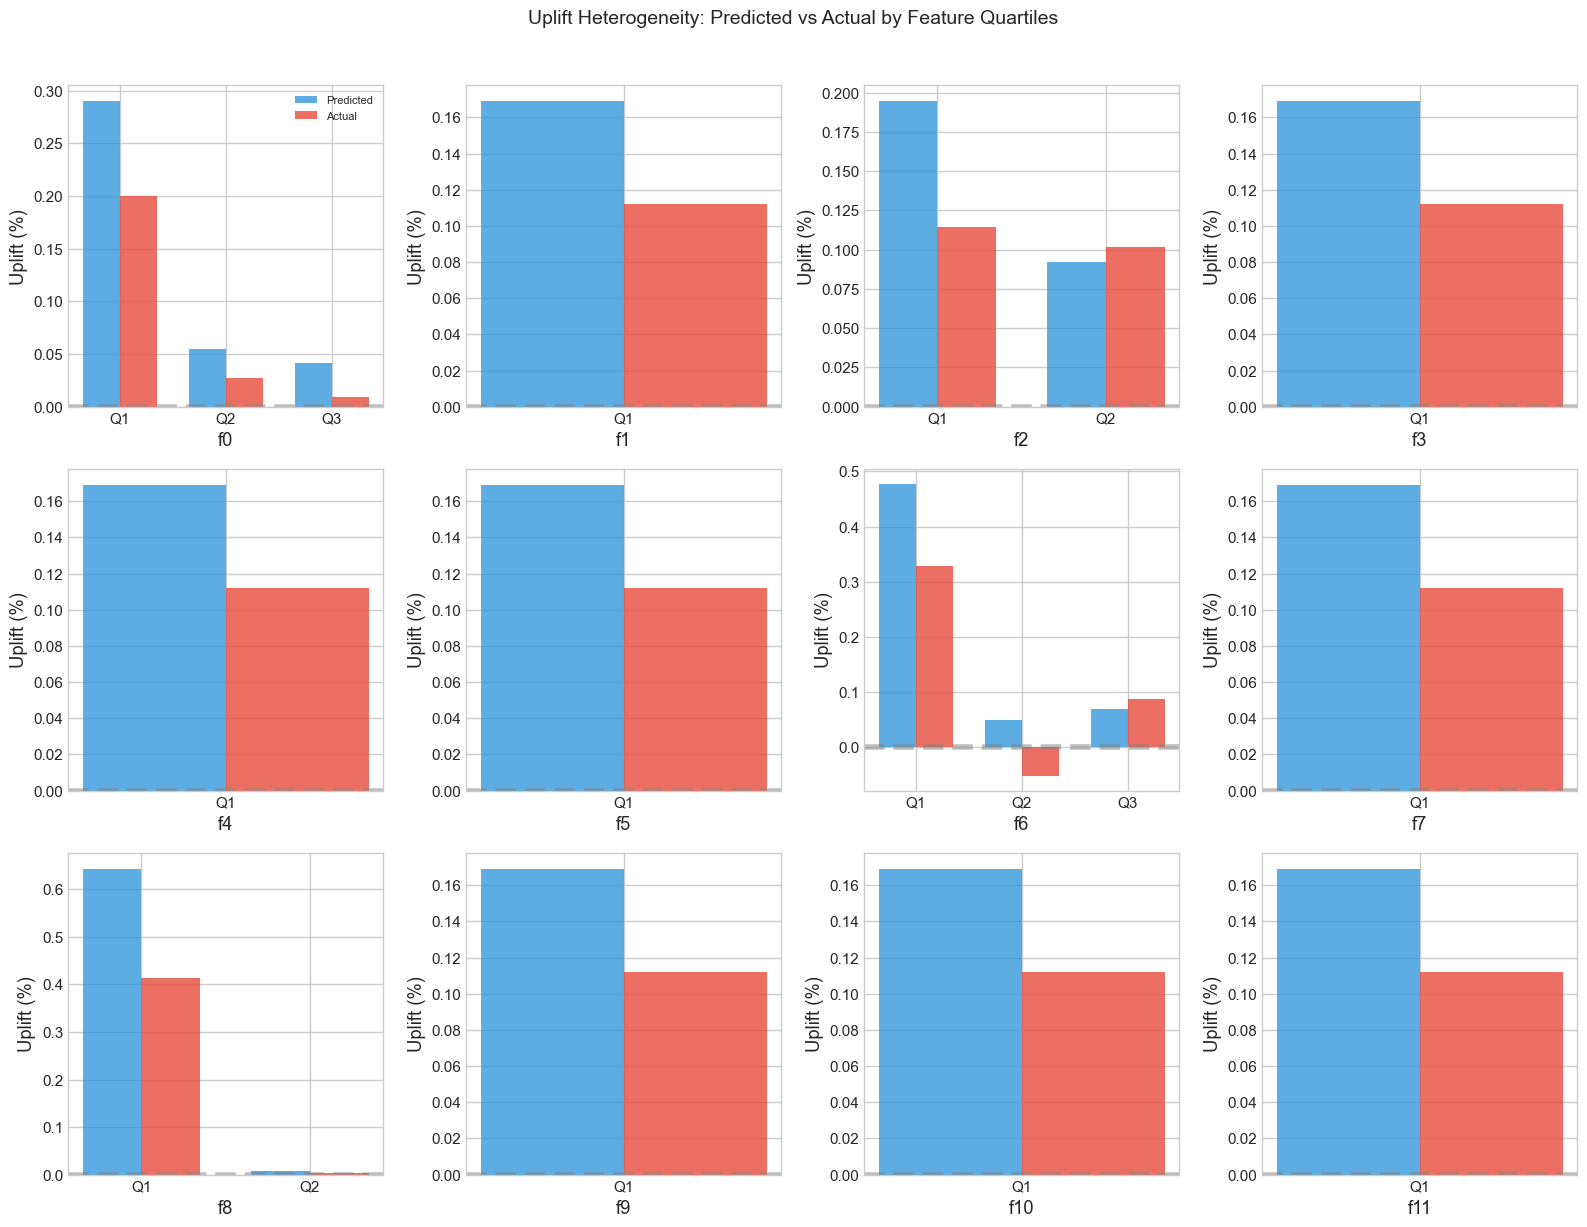

In [18]:
# Create analysis DataFrame
analysis_df = pd.DataFrame(X_test, columns=feature_cols)
analysis_df['uplift_pred'] = uplift_rf_scores
analysis_df['y'] = y_test
analysis_df['treatment'] = t_test

# Analyze uplift by quartiles of each feature
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(feature_cols):
    ax = axes[i]
    
    # Create quartiles for this feature
    # Use labels=False first, then map to handle variable number of bins after dropping duplicates
    try:
        quartile_values = pd.qcut(analysis_df[feature], q=4, labels=False, duplicates='drop')
        n_bins = quartile_values.nunique()
        label_map = {j: f'Q{j+1}' for j in range(n_bins)}
        analysis_df[f'{feature}_q'] = quartile_values.map(label_map)
    except ValueError:
        # Fallback: use fewer bins if quartiles fail
        analysis_df[f'{feature}_q'] = pd.cut(analysis_df[feature], bins=3, labels=['Low', 'Med', 'High'])
    
    # Calculate mean predicted uplift by quartile
    uplift_by_q = analysis_df.groupby(f'{feature}_q')['uplift_pred'].mean() * 100
    
    # Also calculate actual uplift by quartile
    actual_uplift = analysis_df.groupby(f'{feature}_q').apply(
        lambda g: g[g['treatment']==1]['y'].mean() - g[g['treatment']==0]['y'].mean() if len(g[g['treatment']==0]) > 0 and len(g[g['treatment']==1]) > 0 else 0
    ) * 100
    
    # Plot
    x = range(len(uplift_by_q))
    width = 0.35
    ax.bar([xi - width/2 for xi in x], uplift_by_q.values, width, label='Predicted', color='#3498db', alpha=0.8)
    ax.bar([xi + width/2 for xi in x], actual_uplift.values, width, label='Actual', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Uplift (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(uplift_by_q.index)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    if i == 0:
        ax.legend(fontsize=8)

plt.suptitle('Uplift Heterogeneity: Predicted vs Actual by Feature Quartiles', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


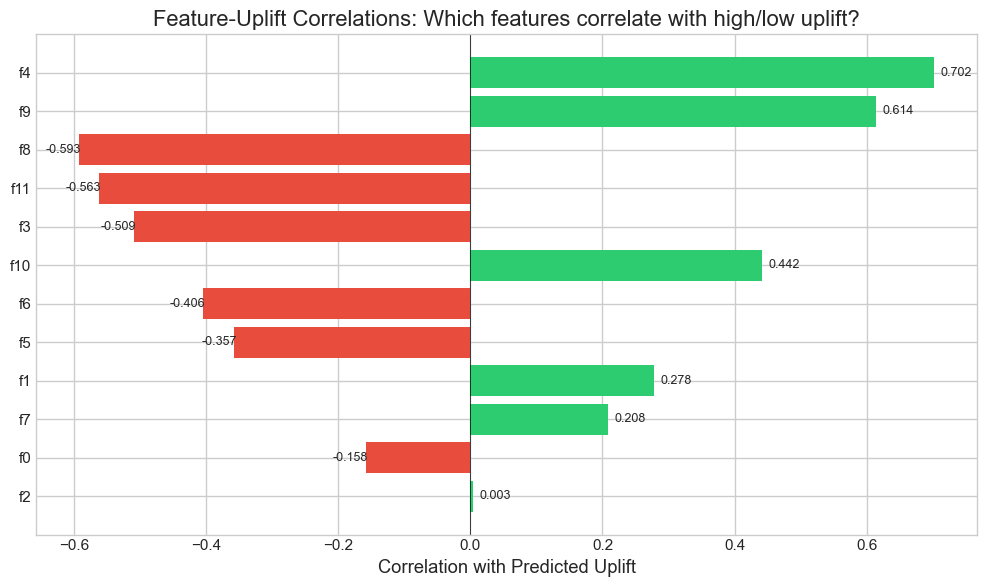

Interpretation:
• Positive correlation: Higher feature value → Higher predicted uplift
• Negative correlation: Higher feature value → Lower predicted uplift

Top features for identifying Persuadables:


,Feature,Correlation with Uplift
4,f4,0.702343
9,f9,0.613533
8,f8,-0.592726
11,f11,-0.562590
3,f3,-0.509153


In [17]:
# Feature-Uplift correlation analysis
# Which features have the strongest relationship with predicted uplift?

correlations = []
for feat in feature_cols:
    corr = np.corrcoef(analysis_df[feat], analysis_df['uplift_pred'])[0, 1]
    correlations.append({'Feature': feat, 'Correlation with Uplift': corr})

corr_df = pd.DataFrame(correlations).sort_values('Correlation with Uplift', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in corr_df['Correlation with Uplift']]
bars = ax.barh(corr_df['Feature'], corr_df['Correlation with Uplift'], color=colors)
ax.set_xlabel('Correlation with Predicted Uplift')
ax.set_title('Feature-Uplift Correlations: Which features correlate with high/low uplift?')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.invert_yaxis()

# Add annotations
for bar, val in zip(bars, corr_df['Correlation with Uplift']):
    ax.text(bar.get_width() + 0.01 if val >= 0 else bar.get_width() - 0.05, 
            bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("• Positive correlation: Higher feature value → Higher predicted uplift")
print("• Negative correlation: Higher feature value → Lower predicted uplift")
print("\nTop features for identifying Persuadables:")
corr_df.head()


## 6. Summary & Key Takeaways

### Models Compared in This Notebook:

| Model | Library | Key Feature |
|-------|---------|-------------|
| **Uplift Random Forest** | CausalML | Splits on uplift heterogeneity (KL divergence) |
| **Causal Forest** | EconML | Honest estimation + confidence intervals |

### Feature Importance Insights:

Understanding which features drive treatment effect heterogeneity is crucial for:

1. **Targeting Strategy**: Focus marketing on segments with highest uplift
2. **Feature Engineering**: Create more granular features from important variables
3. **Business Understanding**: Know *why* certain users respond better

### Causal Trees vs. Meta-Learners:

| Aspect | Meta-Learners (T/S/X) | Causal Trees |
|--------|----------------------|--------------|
| Optimization | Prediction accuracy | Uplift heterogeneity |
| Interpretability | Depends on base model | High (tree structure) |
| Confidence Intervals | Not built-in | Built-in (EconML) |
| Flexibility | Any base model | Fixed structure |
| Complexity | Varies | Moderate |

### When to Use Each:

- **Meta-Learners**: When you have a preferred ML model, or need flexibility
- **Causal Trees**: When interpretability and confidence intervals matter
- **Both**: Compare and ensemble for robustness!
